In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
import pickle #to download MLP vectors
from scipy.stats import percentileofscore
import random
from scipy.stats import pearsonr, spearmanr
from scipy.stats import skew, kurtosis
from scipy import stats

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

C:\Users\camil\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\camil\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import nbrh_WG_open, mid_cum_Z4_sec, starting_h_day, FB_process
import config_exp2 as config

C:\Users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
C:\Users\camil\anaconda3\lib\site-packages\gensim\matutils.py:24: DeprecationWarning: Please use `triu` from the `scipy.linalg` namespace, the `scipy.linalg.special_matrices` namespace is deprecated.
  from scipy.linalg.special_matrices import triu
C:\Users\camil\anaconda3\lib\site-packages\xgboost\compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


2


In [3]:
path_extracted_data = config.path_extracted_data
#VTDperhour PropZ5 zonecrossed2transition unevenness
path_save_all = os.path.join(path_extracted_data,'LongformatModels')

# download data

In [4]:
model_name = '_KBF_trend_rs0FinalciBHV_'
model_name = '_KBF_trend_rs0_'
model_name = '_KBF_trend_rs0NEW_'
glob.glob(os.path.join(path_save_all,'*'+model_name,'*'+model_name+'df_discretedrift.csv'))

['G:\\VPHI\\Welfare\\2- Research Projects\\Camille Montalcini\\Origins.GS\\DataOutput\\TrackingSystem\\EXP2_\\LongformatModels\\PropZ5_KBF_trend_rs0NEW_\\PropZ5_KBF_trend_rs0NEW_df_discretedrift.csv',
 'G:\\VPHI\\Welfare\\2- Research Projects\\Camille Montalcini\\Origins.GS\\DataOutput\\TrackingSystem\\EXP2_\\LongformatModels\\unevenness_KBF_trend_rs0NEW_\\unevenness_KBF_trend_rs0NEW_df_discretedrift.csv',
 'G:\\VPHI\\Welfare\\2- Research Projects\\Camille Montalcini\\Origins.GS\\DataOutput\\TrackingSystem\\EXP2_\\LongformatModels\\VTDperhour_KBF_trend_rs0NEW_\\VTDperhour_KBF_trend_rs0NEW_df_discretedrift.csv',
 'G:\\VPHI\\Welfare\\2- Research Projects\\Camille Montalcini\\Origins.GS\\DataOutput\\TrackingSystem\\EXP2_\\LongformatModels\\zonecrossed2transitionds1_KBF_trend_rs0NEW_\\zonecrossed2transitionds1_KBF_trend_rs0NEW_df_discretedrift.csv',
 'G:\\VPHI\\Welfare\\2- Research Projects\\Camille Montalcini\\Origins.GS\\DataOutput\\TrackingSystem\\EXP2_\\LongformatModels\\zonecrossed2tr

In [5]:
dico_vars_name = {'dynKBF.dynKBF':'KBF-->KBF', 'dynBHV.dynKBF':'KBF-->BHV', 'dynKBF.dynBHV':'BHV-->KBF', 'dynBHV.dynBHV':'BHV-->BHV'}
li_df = []
for path_ in glob.glob(os.path.join(path_save_all,'*'+model_name, '*'+model_name+'df_discretedrift.csv')):
    BHV_name = path_.split('\\')[-1].split(model_name)[0]
    if BHV_name not in ['zonecrossed2transitionds2']:
        #discrete drift
        df_lag = pd.read_csv(path_,sep=',',index_col=0)
        #print(df_lag.shape)
        df_dd = df_lag.transpose()
        df_dd['var']  = df_dd.index
        df_dd['time2shock'] = df_dd['var'].map(lambda x: float('.'.join(re.findall(r'\d+', x))))
        df_dd['var2'] = df_dd['var'].map(lambda x: x.split('.')[-1])
        df_dd['var1'] = df_dd['var'].map(lambda x: x.split('.')[-2])
        df_dd['vars'] = df_dd['var'].map(lambda x: x.split('.')[-2]+'.'+x.split('.')[-1])
        #display(df_dd['var1'].value_counts())
        #display(df_dd['var2'].value_counts())
        df_dd = df_dd[(df_dd['var1'].isin(['dynKBF','dynBHV']))&(df_dd['var2'].isin(['dynKBF','dynBHV']))]
        #print(df_dd.shape)
        #display(df_dd['time2shock'].value_counts())
        #display(df_dd['vars'].value_counts())
        df_dd['97.5%'] = df_dd.apply(lambda x: np.quantile([x[i] for i in [c for c in df_dd.columns if str(c).isdigit()]], 0.975), axis=1)
        df_dd['2.5%'] = df_dd.apply(lambda x: np.quantile([x[i] for i in [c for c in df_dd.columns if str(c).isdigit()]], 0.025), axis=1)
        df_dd['5%'] = df_dd.apply(lambda x: np.quantile([x[i] for i in [c for c in df_dd.columns if str(c).isdigit()]], 0.95), axis=1)
        df_dd['95%'] = df_dd.apply(lambda x: np.quantile([x[i] for i in [c for c in df_dd.columns if str(c).isdigit()]], 0.05), axis=1)
        df_dd['Mean'] = df_dd.apply(lambda x: np.mean([x[i] for i in [c for c in df_dd.columns if str(c).isdigit()]]), axis=1)
        df_dd['BHV_name'] = BHV_name
        df_dd['varname'] = df_dd['vars'].map(lambda x: dico_vars_name[x])
        print(df_dd.shape)
        #display(df_dd.head(3))
        li_df.append(df_dd[['97.5%','2.5%','5%','95%','Mean','BHV_name','varname','time2shock']])
df_t2s = pd.concat(li_df)
display(df_t2s['BHV_name'].value_counts())
print(df_t2s.shape)
display(df_t2s.head(3))

(404, 1012)
(404, 1012)
(404, 1012)
(404, 1012)


PropZ5                       404
unevenness                   404
VTDperhour                   404
zonecrossed2transitionds1    404
Name: BHV_name, dtype: int64

(1616, 8)


,97.5%,2.5%,5%,95%,Mean,BHV_name,varname,time2shock
popmean.0.dynKBF.dynKBF,1.000000,1.000000,1.000000,1.000000,1.000000,PropZ5,KBF-->KBF,0.0
popmean.0.1.dynKBF.dynKBF,0.969201,0.892441,0.965907,0.901826,0.938393,PropZ5,KBF-->KBF,0.1
popmean.0.2.dynKBF.dynKBF,0.939413,0.796452,0.932985,0.813327,0.880974,PropZ5,KBF-->KBF,0.2


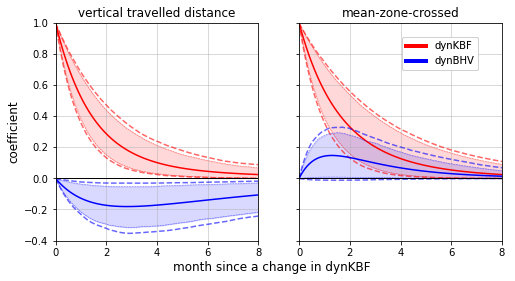

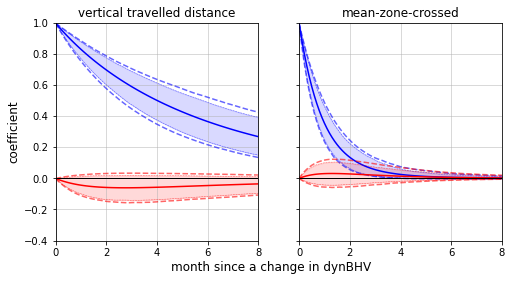

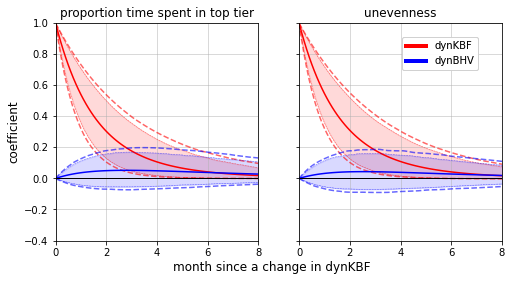

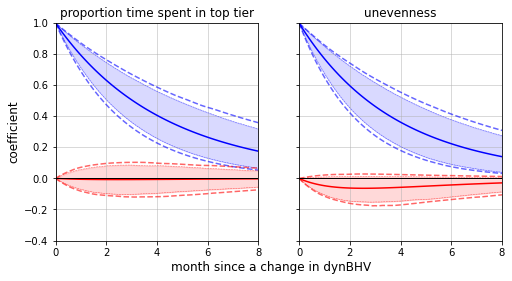

In [6]:
custom_lines = [Line2D([0], [0], color='red', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
li_dico_BHV_name = [{'VTDperhour':'vertical travelled distance',
                'zonecrossed2transitionds1':'mean-zone-crossed'},
                 {'PropZ5':'proportion time spent in top tier',
                'unevenness':'unevenness'}]

for dico_BHV_name, BHVtype in zip(li_dico_BHV_name,['movementBHV','SpaceUseBHV']):
    #for df_t2s,vis_name in zip([df_t2s_ind,df_t2s_cor],['IndPerturb','CorrPerturb']):
    for dico_vars_color,title in  zip([{'KBF-->KBF':'red', 'KBF-->BHV':'blue'},
                                       {'BHV-->BHV':'blue', 'BHV-->KBF':'red'}],
                                      ['change in dynKBF','change in dynBHV']):
        c = 2 ; l = 1
        img_w = 4 ; img_h = 4
        fig = plt.figure(figsize=(img_w*c, img_h*l))
        i = 1
        for BHV in dico_BHV_name.keys():
            df_plt = df_t2s[df_t2s['BHV_name']==BHV].copy()
            plt.subplot(l,c,i)
            #plt.tight_layout()
            for t,color in dico_vars_color.items():
                v = df_plt[df_plt['varname']==t]
                x = v['time2shock']
                y_est = v['Mean'] ; y_lb = v['2.5%'] ; y_hb = v['97.5%'] ; y_lb_tend = v['5%'] ; y_hb_tend = v['95%']
                plt.plot(x, y_est, '-',color=color)
                plt.plot(x, y_lb, '--',color=color,alpha=0.6)
                plt.plot(x, y_hb, '--',color=color,alpha=0.6)
                plt.plot(x, y_lb_tend, '--',color=color,alpha=0.6, linewidth=0.5)
                plt.plot(x, y_hb_tend, '--',color=color,alpha=0.6, linewidth=0.5)
                plt.fill_between(x, y_lb_tend, y_hb_tend, alpha=0.15,color=color);
                plt.xlim(0,8)
                plt.ylim(-0.4,1)
                plt.ylabel('')
                plt.xlabel('')
                if i<3:
                    plt.title(dico_BHV_name[BHV], size=12)
                if i not in [1,3]:
                    plt.yticks(color='white')
                #if (i==1)&(title=='change in dynKBF'):
                if i==1:
                    plt.ylabel('coefficient',size=12)
                else:
                    plt.yticks(color='white')
                    plt.ylabel('')
                plt.grid(True, alpha=0.6)
                plt.axhline(0,color='black',linewidth=1) #linestyle=':',
            i = i +1
        fig.text(0.5, 0.02, 'month since a '+title, ha='center', size=12)
        if title=='change in dynKBF':
            #fig.text(0.08, 0.5, 'coefficient', va='center', rotation='vertical', size=13);
            #fig.text(0.91, 0.614, 'change in dynBHV', ha='center', rotation=270, size=13)
            #fig.text(0.91, 0.19, 'change in dynKBF', ha='center', rotation=270, size=13)
            fig.legend(custom_lines, ['dynKBF', 'dynBHV'], loc=(0.78, 0.75));
            fig.legend(custom_lines, ['dynKBF', 'dynBHV'], loc=(0.78, 0.75));
        plt.savefig(os.path.join(path_save_all,BHVtype+'_'+title.replace(' ','')+'_dtDRIFT.png'),dpi=300,format='png', bbox_inches='tight')
        plt.show();

In [7]:
df_t2s[(df_t2s['BHV_name']=='VTDperhour')&(df_t2s['varname']=='KBF-->BHV')&(df_t2s['time2shock']<3)]

,97.5%,2.5%,5%,95%,Mean,BHV_name,varname,time2shock
popmean.0.dynBHV.dynKBF,0.000000,0.000000,0.000000,0.000000,0.000000,VTDperhour,KBF-->BHV,0.0
popmean.0.1.dynBHV.dynKBF,-0.002990,-0.034202,-0.005257,-0.031846,-0.018621,VTDperhour,KBF-->BHV,0.1
popmean.0.2.dynBHV.dynKBF,-0.005812,-0.065269,-0.010066,-0.060599,-0.035666,VTDperhour,KBF-->BHV,0.2
popmean.0.3.dynBHV.dynKBF,-0.008472,-0.094073,-0.014459,-0.086778,-0.051253,VTDperhour,KBF-->BHV,0.3
popmean.0.4.dynBHV.dynKBF,-0.010966,-0.119961,-0.018473,-0.110969,-0.065492,VTDperhour,KBF-->BHV,0.4
popmean.0.5.dynBHV.dynKBF,-0.013265,-0.143475,-0.022144,-0.132607,-0.078483,VTDperhour,KBF-->BHV,0.5
popmean.0.6.dynBHV.dynKBF,-0.015409,-0.164569,-0.025489,-0.152383,-0.090318,VTDperhour,KBF-->BHV,0.6
popmean.0.7.dynBHV.dynKBF,-0.017406,-0.184423,-0.028530,-0.169999,-0.101084,VTDperhour,KBF-->BHV,0.7
popmean.0.8.dynBHV.dynKBF,-0.019263,-0.201516,-0.031291,-0.186741,-0.110860,VTDperhour,KBF-->BHV,0.8
popmean.0.9.dynBHV.dynKBF,-0.020987,-0.216469,-0.033790,-0.202182,-0.119720,VTDperhour,KBF-->BHV,0.9


In [1]:
 0.17 * 1.79

0.3043

In [ ]:
TODOOOOOO from here on

In [ ]:
#TODOdiscretetime diffusion?? i.e. correalted change?

# download the data

In [13]:
#daily var
#eta1=latent process of well-being; eta2=latent process of frequency/duration of use
df = pd.read_csv(os.path.join(path_save,name+'HenIDParameters.csv'), index_col=0, sep=',')
li_indestimate = [i for i in df.columns if i!='id']
print(df.shape)
#add hen info
df_hen = df_init[['id','HenID','ExperimentID','Is_relocated','IsOFH','early_death']].drop_duplicates()
print(df_hen.shape)
df_hen.head(3)
df = pd.merge(df, df_hen, on=['id'], how='left')
df.head(3)

(334, 15)
(334, 6)


,drift_dynKBF,drift_dynKBF_dynVTD,drift_dynVTD,drift_dynVTD_dynKBF,drift_KBF,drift_VTD,mm_Y1,mm_Y2,mvarY1,mvarY2,T0m_cintKBF,T0m_cintVTD,T0m_KBF,T0m_VTD,id,HenID,ExperimentID,Is_relocated,IsOFH,early_death
0,-0.130240,-0.282336,-0.272780,0.112304,-0.427050,-0.040215,3.046796,3.382612,0.440481,0.556663,-1.559623,-0.222859,-4.019168,-2.785857,1,EXP2_hen_1,Exp2,1,0,0.0
1,-0.130721,-0.286685,-0.077758,0.126251,-0.418834,-0.038456,3.042038,3.404769,0.444549,0.611760,-1.414343,-0.200018,-4.106888,-2.442259,2,EXP2_hen_10,Exp2,1,0,0.0
2,-0.129530,-0.251412,-0.018685,0.110248,-0.481049,-0.033974,3.204710,3.791477,0.312825,0.722830,-1.822963,-0.245653,-3.955779,-2.478304,3,EXP2_hen_100,Exp2,1,0,0.0


# compare with real data

In [57]:
#do scatter plot age kbf age vtd and kbf vtd....
#do tsem with age instead of vtd!

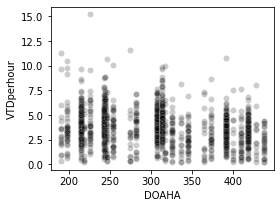

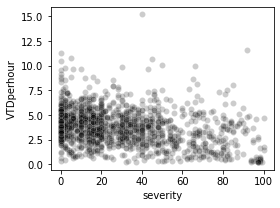

In [58]:
plt.figure(figsize=(4,3))
sns.scatterplot(x='DOAHA', y='VTDperhour', color='black', data=df_init, alpha=0.2);
plt.figure(figsize=(4,3))
sns.scatterplot(x='severity', y='VTDperhour', color='black', data=df_init, alpha=0.2);
#--> VTDperhour reduce more over severity than DOAHA. I believe the model: the more severe the lesser you move

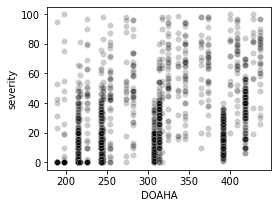

In [59]:
plt.figure(figsize=(4,3))
sns.scatterplot(x='DOAHA', y='severity', color='black', data=df_init, alpha=0.2);

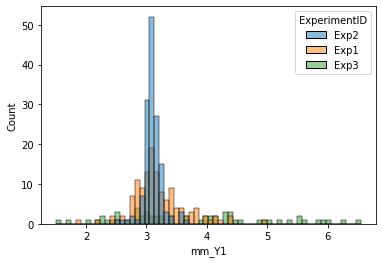

In [60]:
sns.histplot(df, x='mm_Y1', hue='ExperimentID', fill=True); 

### TICov differ?

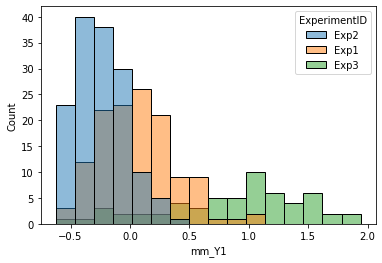

In [11]:
sns.histplot(df, x='mm_Y1', hue='ExperimentID', fill=True); 

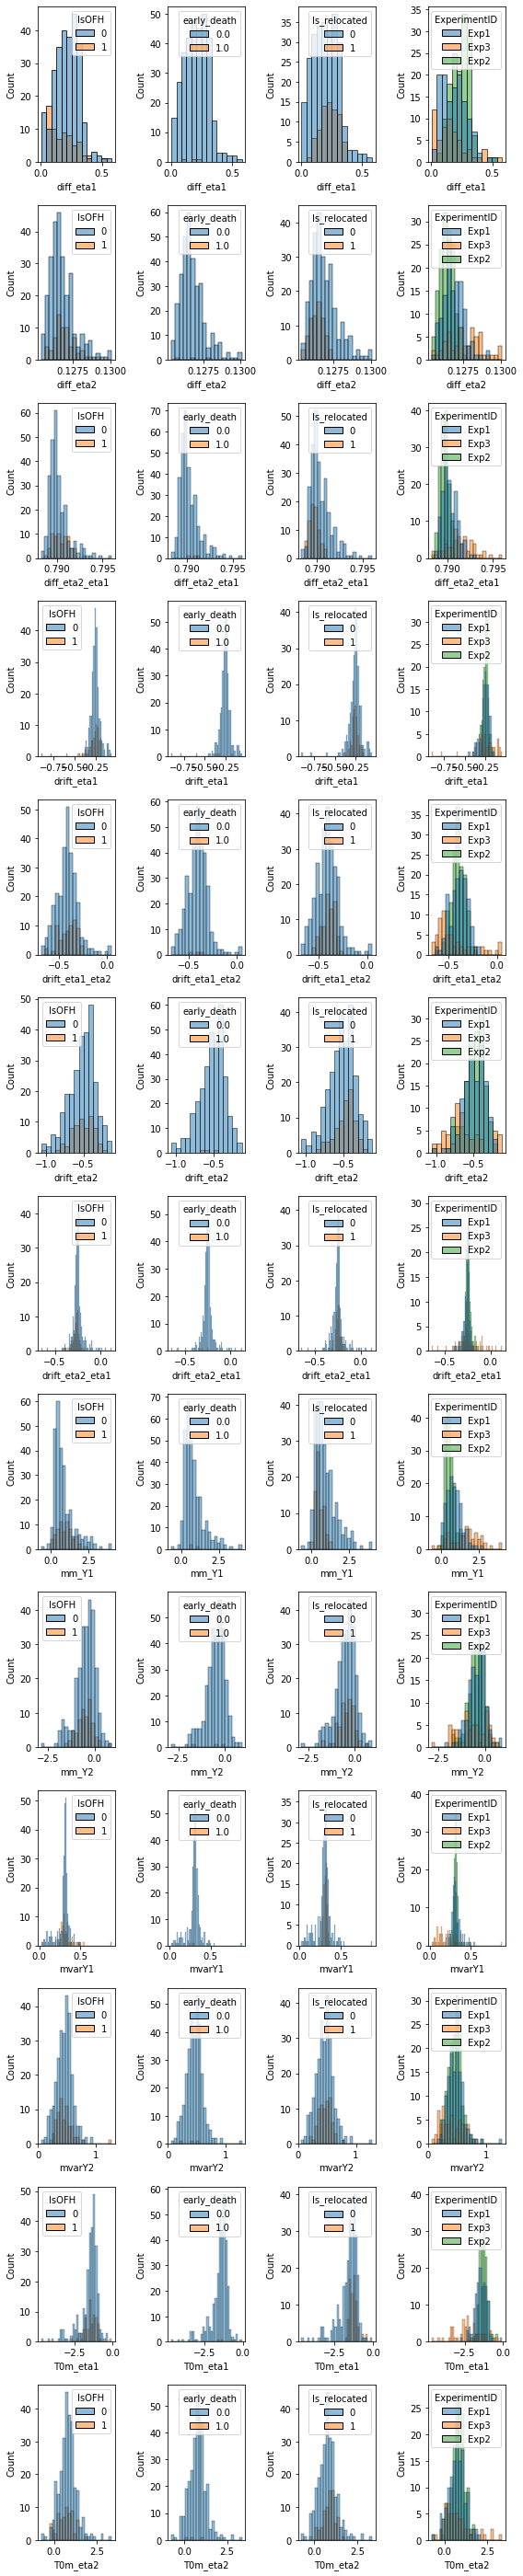

In [7]:
li_cov = ['IsOFH','early_death','Is_relocated','ExperimentID']
c = len(li_cov) ; l = len(li_indestimate)
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v in li_indestimate:
    for h in li_cov:
        plt.subplot(l,c,i)
        plt.tight_layout()
        #plt.figure(figsize=(2,3))
        #plt.grid(True)
        #plt.hist(df[v], color='lightgrey',edgecolor = "black",bins=15);
        #sns.displot(df, x=v, hue=h, kind="kde", fill=True); #does not work, shouldspecify axis
        sns.histplot(df, x=v, hue=h, fill=True); 
        i = i+1
plt.savefig(os.path.join(path_save,name+'TICovdifference.png'),dpi=300,format='png',
            bbox_inches='tight')
plt.show()

### Var in mvt associates with mean in KBF?

SpearmanrResult(correlation=0.969268401478608, pvalue=2.807157095939286e-204)
PearsonRResult(statistic=0.9302453759131697, pvalue=1.3093063211915346e-146)
-------------------------
SpearmanrResult(correlation=-0.13956322932996454, pvalue=0.01066285438832268)
PearsonRResult(statistic=-0.29902125485652775, pvalue=2.51351941617484e-08)
-------------------------
SpearmanrResult(correlation=-0.04857521745536761, pvalue=0.37618960538908186)
PearsonRResult(statistic=-0.24716134883335122, pvalue=4.848909121812093e-06)


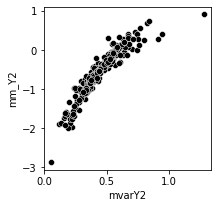

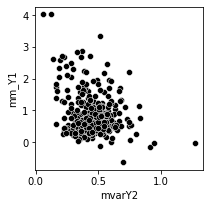

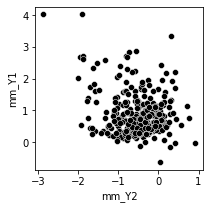

In [8]:
#does hens that have more variation in VTD have lesser intercept of KBF?
#MAYBE: TODO: add all data, and test if mvarY1 or T0var exhibit a different drift
#color='black',hue=df['ExperimentID'].tolist()
plt.figure(figsize=(3,3))
sns.scatterplot(x='mvarY2', y='mm_Y2', color='black', data=df); #hens that vary a lot have higher mvt
print(spearmanr(df['mvarY2'].tolist(), df['mm_Y2'].tolist())) #stats on stats, but we have the real correlation in the results
print(pearsonr(df['mvarY2'].tolist(), df['mm_Y2'].tolist()))

print('-------------------------')
plt.figure(figsize=(3,3))
sns.scatterplot(x='mvarY2', y='mm_Y1', color='black', data=df); #hens that vary a lot may have lower intercept of KBF
print(spearmanr(df['mvarY2'].tolist(), df['mm_Y1'].tolist()))
print(pearsonr(df['mvarY2'].tolist(), df['mm_Y1'].tolist()))

print('-------------------------')
plt.figure(figsize=(3,3))
sns.scatterplot(x='mm_Y2', y='mm_Y1', color='black',data=df); #hens that have a higher VTD interecept, do not have more or less KBF
print(spearmanr(df['mm_Y2'].tolist(), df['mm_Y1'].tolist()))
print(pearsonr(df['mm_Y2'].tolist(), df['mm_Y1'].tolist()))

### does hens that have lower VTD have a stronger influence of their mvt on the KBF?

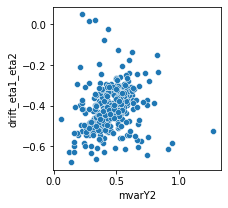

In [9]:
#does hens that have lower VTD have a stronger influence of their mvt on the KBF?
plt.figure(figsize=(3,3))
sns.scatterplot(x='mvarY2',y='drift_eta1_eta2', data=df);
# not so clear

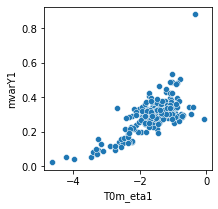

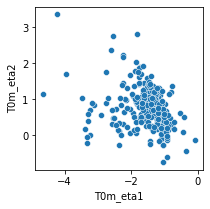

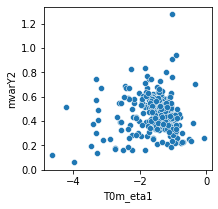

In [10]:
#TODO: THINK ABOUT
plt.figure(figsize=(3,3))
sns.scatterplot(x='T0m_eta1',y='mvarY1', data=df);
plt.figure(figsize=(3,3))
sns.scatterplot(x='T0m_eta1',y='T0m_eta2', data=df);
plt.figure(figsize=(3,3))
sns.scatterplot(x='T0m_eta1',y='mvarY2', data=df);

### mm_- baseline level: ind diff in intercept

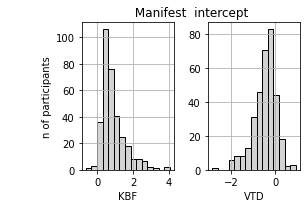

In [20]:
# mm_ : Manifest  means (mm) show the continuous manifest intercept, reflecting between-ind. differences in  baseline levels
c = 2 ; l = 1
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v,name_plt in zip(['mm_Y1','mm_Y2'],['KBF','VTD']):
    plt.subplot(l,c,i)
    plt.tight_layout()
    #plt.figure(figsize=(2,3))
    plt.grid(True)
    plt.hist(df[v], color='lightgrey',edgecolor = "black",bins=15);
    if i==1:
        plt.ylabel('n of participants')
        plt.title('                                 Manifest  intercept')
    plt.xlabel(name_plt)
    i = i+1
plt.savefig(os.path.join(path_save,name+'distribution_T0m.png'),dpi=300,format='png',
            bbox_inches='tight')
plt.show()
#KBF is postive meaning thatKBF

### mvar_ - var/cov of manifest indicators

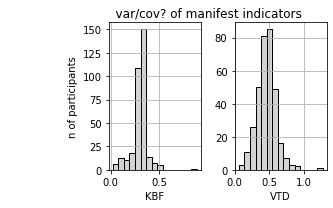

In [12]:
### mvar : variance of manifest indicators reflects the within-person variability in measurement error, and unsurprisingly, 
#it is higher for KBF, indicating that measures of  KBF  tend  to  fluctuate more 
c = 2 ; l = 1
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v,name_plt in zip(['mvarY1','mvarY2'],['KBF','VTD']):
    plt.subplot(l,c,i)
    plt.tight_layout()
    #plt.figure(figsize=(2,3))
    plt.grid(True)
    plt.hist(df[v], color='lightgrey',edgecolor = "black",bins=15);
    if i==1:
        plt.ylabel('n of participants')
        plt.title('                            var/cov? of manifest indicators')
    plt.xlabel(name_plt)
    i = i+1
plt.savefig(os.path.join(path_save,name+'distribution_T0m.png'),dpi=300,format='png',
            bbox_inches='tight')
plt.show()

# T0m_ - initial stage w.r.t later stages

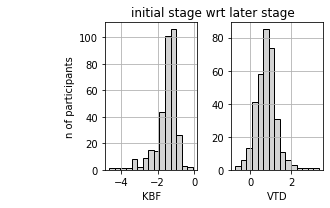

In [13]:
#T0m_eta2  is  the  initial  stage  of  the VTD latent  processe with  respect  to  later stages. Positive  values  indicate  
#that  initial  level  of  VTD  is  higher  than  at  later  stages,  i.e.  VTD  diminish  as  time  goes  by.
#DONT confuse initial stage with starting values...
c = 2 ; l = 1
img_w = 2 ; img_h = 3 
fig = plt.figure(figsize=(img_w*c, img_h*l))
i = 1
for v,name_plt in zip(['T0m_eta1','T0m_eta2'],['KBF','VTD']):
    plt.subplot(l,c,i)
    plt.tight_layout()
    #plt.figure(figsize=(2,3))
    plt.grid(True)
    plt.hist(df[v], color='lightgrey',edgecolor = "black",bins=15);
    if i==1:
        plt.ylabel('n of participants')
        plt.title('                                initial stage wrt later stage')
    plt.xlabel(name_plt)
    i = i+1
plt.savefig(os.path.join(path_save,name+'distribution_T0m.png'),dpi=300,format='png',
            bbox_inches='tight')
plt.show()